# Data Engineer Data Pipeline

This project builds a data pipeline utlizing the ETL process.  The python script does the following automatically:

-Extracts an excel worbkook with two sheets containing one with jumbled data (data sheet) and another with officer name/code data (officer codes sheet).


-Creates a dictionary based on the officer name and their code found in the officer codes sheet.  This is to ensure data integrity and that the correct officer name is linked to their correct officer code throughout the script.  


-Transforms and cleans the data sheet by checking if the primary officer name exists (from the created dictionary) and then if their officer name/code is correct, it updates the secondary officer name and secondary officer code to match.  If an officer code isn't correct or the names aren't consistent, it updates them.  If there is an uknown primary officer name, a new sheet (incorrect row data) is created with those rows to examine further.  It also prints helpful info on the incorrect data.  


-Creates a new worksheet named 'Cleaned Data' and loads the updated data into it.


-Creates a new worksheet named 'Incorrect Row Data' and loads the incorrect rows (uknown primary officer names) into it.


-Loads the cleaned data into a SQL server database table by first connecting to SQL server using the pyodbc module and then loading the data into the table.  

New data or additional officers could be added later and the script will include the additional info and ensure data integrity.  

The script is also flexible enough that if a new officer is listed in or if a new person takes over a current officer code, it is easy to adjust to ensure the data integrity is kept and data is updated correctly. 

## Tech Stack Used:
-Python:  openpyxl, pandas, and pyodbc modules

-SQL

-SQL Server database

# Initial Workbook Image
![Test%20Image%201.png](Test%20Image%201.PNG)

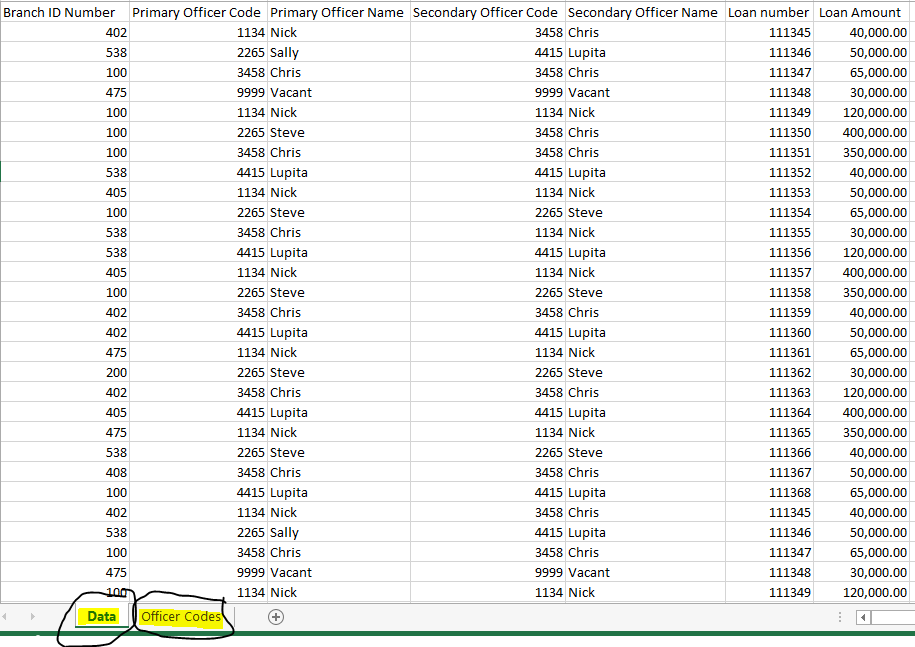

In [184]:
# importing the needed modules.  
import openpyxl
import pandas as pd
import pyodbc

In [185]:
# There are two sheets in this excel workbook.  The data sheet and another sheet called officer codes. 
pandas_main_data = pd.read_excel('Fictional Data.xlsx', sheet_name=0) # data sheet
pandas_officer_codes = pd.read_excel('Fictional Data.xlsx', sheet_name=1) # officer codes sheet.

pandas_main_data.head() # displaying a sample of the data sheet.

,Branch ID Number,Primary Officer Code,Primary Officer Name,Secondary Officer Code,Secondary Officer Name,Loan number,Loan Amount
0,402,1134,Nick,3458,Chris,111345,40000
1,538,2265,Sally,4415,Lupita,111346,50000
2,100,3458,Chris,3458,Chris,111347,65000
3,475,9999,Vacant,9999,Vacant,111348,30000
4,100,1134,Nick,1134,Nick,111349,120000


In [186]:
# officer codes sheet
pandas_officer_codes # displaying the officer codes sheet.

,Officer Name,Officer Code
0,Nick,1134
1,Steve,2265
2,Chris,3458
3,Lupita,4415


# Explanation of the Data

### Data Sheet:
-Branch ID Number: The bank branch that houses the loan.

-Primary Officer Code: The officer code of the primary officer

-Primary Officer Name: The individual assigned to the loan.

-Secondary Officer Code: The second level officer code.

-Secondary Officer Name: The name of the officer.

-Loan number: Loan number of the individual loan.

-Loan Amount: Amount of the individual loan.

 ### Officer Codes Sheet:




-Officer Name: Officer name

-Officer code:  Their correct officer number

The script first looks at the primary officer name, ensures the officer exists and then checks if the primary officer code matches to them.  If not, it updates the primary officer code and then updates the secondary officer code and name rows so the data is consistent throughout.

If the primary officer name doesn't exist, those rows are appendended to a new lista new list to inspect further.  

For example, Nick's correct officer code is 1134 (shown below).  In the main data, if Nick is listed as the primary officer
but the primary officer code lists 7819, the script updates the code to 1134.  

If Steve is listed as a primary officer but Lupita is listed as the secondary officer, the script updates
the secondary officer to Steve and the officer code gets updated to 2265 (Steve's officer code) as well.

In [187]:
# officer codes sheet
pandas_officer_codes

,Officer Name,Officer Code
0,Nick,1134
1,Steve,2265
2,Chris,3458
3,Lupita,4415


In [188]:
# This begins the script:

# opening the excel sheet in openpyxl and assiging each sheet to a variable.
workbook = openpyxl.load_workbook('Fictional Data.xlsx')
main_data = workbook['Data']
officer_codes = workbook['Officer Codes']

In [189]:
# creates a dictionary that maps the officer to their correct code.
# This will allow the script to check and update incorrect officer codes and names later on.
officer_dictionary = {}
for row in officer_codes.iter_rows(min_row=2, values_only=True): # min_row =2 skips the header row
    name = row[0]
    code = row[1]
    officer_dictionary[name] = code
officer_dictionary

{'Nick': 1134, 'Steve': 2265, 'Chris': 3458, 'Lupita': 4415}

In [190]:
# openpyxl returns every row as a tuple when iterating through the rows.
# appending the rows as lists instead of tuples to a new list.  Now able to reassign values more easily.   
updated_data = []
for row in main_data.iter_rows(min_row=2, values_only=True): # returns rows of tuples.
    # in order to reasign values later on, the list comprehension returns each row as a list (no tuples). 
    updated_data.append([item for item in row]) 

print("Data before:")
for row in main_data.iter_rows(min_row=2, max_row=6, values_only=True):
    print(row)
print('\n')

print("Data after:")
for row in updated_data[:5]:
    print(row)

Data before:
(402, 1134, 'Nick', 3458, 'Chris', 111345, 40000)
(538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000)
(100, 3458, 'Chris', 3458, 'Chris', 111347, 65000)
(475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000)
(100, 1134, 'Nick', 1134, 'Nick', 111349, 120000)


Data after:
[402, 1134, 'Nick', 3458, 'Chris', 111345, 40000]
[538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000]
[100, 3458, 'Chris', 3458, 'Chris', 111347, 65000]
[475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000]
[100, 1134, 'Nick', 1134, 'Nick', 111349, 120000]


In [191]:
clean_list = []
incorrect_rows = []
for row in updated_data:  # loops through the main_data.  
    primary_code = int(row[1])
    primary_name = row[2]
    secondary_code = int(row[3])
    secondary_name = row[4]

    # checks to see if the primary officer name is in the dictionary and if the code matches to the officer name.
    if primary_name in officer_dictionary and officer_dictionary[primary_name] == primary_code:
        row[4] = primary_name # reassigns the secondary officer name to the primary officer name.
        row[3] = primary_code # reassigns the secondary officer code to the primary officer code.
        clean_list.append(row)
    # if the officer name is in the dictionary but the code is not correct, it updates it to the correct code.
    elif primary_name in officer_dictionary and officer_dictionary[primary_name] != primary_code:
        row[1] = officer_dictionary[primary_name]
        row[4] = primary_name
        row[3] = officer_dictionary[primary_name]
        clean_list.append(row)
    
    # if there is an uknown officer name in the primary officer row, it appends the row to a seperate list. 
    else:
        incorrect_rows.append(row)

In [192]:
# function to print out useful info on the incorrect list that was created. 
def incorrect_row():
    total = 0
    print("These rows have uknown primary officer names (3rd item in row):")
    for row in incorrect_rows:
        name = row[2]
        total += 1
        print(f"Uknown name is {name}: {row}", '\n')
    print(f"There are a total of {total} incorrect rows")

incorrect_row()

These rows have uknown primary officer names (3rd item in row):
Uknown name is Sally: [538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000] 

Uknown name is Vacant: [475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000] 

Uknown name is Sally: [538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000] 

Uknown name is Vacant: [475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000] 

Uknown name is Jimmy: [100, 7812, 'Jimmy', 1002, 'Steve', 111354, 65000] 

There are a total of 5 incorrect rows


In [193]:
workbook.copy_worksheet(main_data) # copies the info and creates a new excel sheet.  

<Worksheet "Data Copy">

In [194]:
new_copy = workbook['Data Copy'] # assigns the new sheet to a variable.
# loops through the data and shows we have the original data (next step is deleting the rows to add in cleaned list).
for row in new_copy.iter_rows(values_only=True):
    print(row)
workbook.save('Fictional Data.xlsx')

('Branch ID Number', 'Primary Officer Code', 'Primary Officer Name', 'Secondary Officer Code', 'Secondary Officer Name', 'Loan number', ' Loan Amount ')
(402, 1134, 'Nick', 3458, 'Chris', 111345, 40000)
(538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000)
(100, 3458, 'Chris', 3458, 'Chris', 111347, 65000)
(475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000)
(100, 1134, 'Nick', 1134, 'Nick', 111349, 120000)
(100, 2265, 'Steve', 3458, 'Chris', 111350, 400000)
(100, 3458, 'Chris', 3458, 'Chris', 111351, 350000)
(538, 4415, 'Lupita', 4415, 'Lupita', 111352, 40000)
(405, 1134, 'Nick', 1134, 'Nick', 111353, 50000)
(100, 2265, 'Steve', 2265, 'Steve', 111354, 65000)
(538, 3458, 'Chris', 1134, 'Nick', 111355, 30000)
(538, 4415, 'Lupita', 4415, 'Lupita', 111356, 120000)
(405, 1134, 'Nick', 1134, 'Nick', 111357, 400000)
(100, 2265, 'Steve', 2265, 'Steve', 111358, 350000)
(402, 3458, 'Chris', 3458, 'Chris', 111359, 40000)
(402, 4415, 'Lupita', 4415, 'Lupita', 111360, 50000)
(475, 1134, 'Nick', 1134

In [195]:
# creates a function to print a sample of the rows in any sheet.  Defaults to the new excel sheet.  
def print_rows(sheetname=new_copy):
    for row in sheetname.iter_rows(min_row=1, values_only=True):
        print(row)  

In [196]:
# # counting how many rows to delete in the new sheet (to then load the cleaned data).
# # total starts at -1 in order to skip the header row.
total = -1 
for row in new_copy:
    total += 1
total

48

In [197]:
# deleting all of the rows except the header row in order to load the cleaned data into the new sheet.
new_copy.delete_rows(idx=2, amount=total)
workbook.save('Fictional Data.xlsx')

# new_copy.delete_rows(idx=2, amount=new_copy.max_row)

print_rows() # showing only the header row remains.

('Branch ID Number', 'Primary Officer Code', 'Primary Officer Name', 'Secondary Officer Code', 'Secondary Officer Name', 'Loan number', ' Loan Amount ')


In [198]:
workbook.copy_worksheet(new_copy)
incorrect = workbook['Data Copy Copy']
workbook.save('Fictional Data.xlsx')
for row in incorrect_rows:
    incorrect.append(row)

In [199]:
# populating the new sheet with the cleaned data.
for row in clean_list:
    new_copy.append(row)

# updated data sheet with the cleaned rows.  
print_rows()

('Branch ID Number', 'Primary Officer Code', 'Primary Officer Name', 'Secondary Officer Code', 'Secondary Officer Name', 'Loan number', ' Loan Amount ')
(402, 1134, 'Nick', 1134, 'Nick', 111345, 40000)
(100, 3458, 'Chris', 3458, 'Chris', 111347, 65000)
(100, 1134, 'Nick', 1134, 'Nick', 111349, 120000)
(100, 2265, 'Steve', 2265, 'Steve', 111350, 400000)
(100, 3458, 'Chris', 3458, 'Chris', 111351, 350000)
(538, 4415, 'Lupita', 4415, 'Lupita', 111352, 40000)
(405, 1134, 'Nick', 1134, 'Nick', 111353, 50000)
(100, 2265, 'Steve', 2265, 'Steve', 111354, 65000)
(538, 3458, 'Chris', 3458, 'Chris', 111355, 30000)
(538, 4415, 'Lupita', 4415, 'Lupita', 111356, 120000)
(405, 1134, 'Nick', 1134, 'Nick', 111357, 400000)
(100, 2265, 'Steve', 2265, 'Steve', 111358, 350000)
(402, 3458, 'Chris', 3458, 'Chris', 111359, 40000)
(402, 4415, 'Lupita', 4415, 'Lupita', 111360, 50000)
(475, 1134, 'Nick', 1134, 'Nick', 111361, 65000)
(200, 2265, 'Steve', 2265, 'Steve', 111362, 30000)
(402, 3458, 'Chris', 3458, 'C

In [200]:
new_copy.title = 'Cleaned Data' # updating the new sheet title.
main_data.title = 'Original Data' # updates the main data title to original data. 
incorrect.title = 'Incorrect Rows Data' # updates incorrect sheet.  

In [201]:
workbook.save('Fictional Data.xlsx')

In [202]:
pandas_updated_list = pd.read_excel('Fictional Data.xlsx', sheet_name=2)
print('Original data sample:')
pandas_main_data.head(10)

Original data sample:


,Branch ID Number,Primary Officer Code,Primary Officer Name,Secondary Officer Code,Secondary Officer Name,Loan number,Loan Amount
0,402,1134,Nick,3458,Chris,111345,40000
1,538,2265,Sally,4415,Lupita,111346,50000
2,100,3458,Chris,3458,Chris,111347,65000
3,475,9999,Vacant,9999,Vacant,111348,30000
4,100,1134,Nick,1134,Nick,111349,120000
5,100,2265,Steve,3458,Chris,111350,400000
6,100,3458,Chris,3458,Chris,111351,350000
7,538,4415,Lupita,4415,Lupita,111352,40000
8,405,1134,Nick,1134,Nick,111353,50000
9,100,2265,Steve,2265,Steve,111354,65000


In [203]:
print('Updated data sample:')
pandas_updated_list.head(10) # the primary officer name and code match.
# it is also consistent with the secondary officer code and name rows too.  

Updated data sample:


,Branch ID Number,Primary Officer Code,Primary Officer Name,Secondary Officer Code,Secondary Officer Name,Loan number,Loan Amount
0,402,1134,Nick,1134,Nick,111345,40000
1,100,3458,Chris,3458,Chris,111347,65000
2,100,1134,Nick,1134,Nick,111349,120000
3,100,2265,Steve,2265,Steve,111350,400000
4,100,3458,Chris,3458,Chris,111351,350000
5,538,4415,Lupita,4415,Lupita,111352,40000
6,405,1134,Nick,1134,Nick,111353,50000
7,100,2265,Steve,2265,Steve,111354,65000
8,538,3458,Chris,3458,Chris,111355,30000
9,538,4415,Lupita,4415,Lupita,111356,120000


In [204]:
pandas_incorrect_rows = pd.read_excel('Fictional Data.xlsx', sheet_name=3) # incorrect rows data. 
print('Incorrect rows data sample:')
pandas_incorrect_rows.head(10)

Incorrect rows data sample:


,Branch ID Number,Primary Officer Code,Primary Officer Name,Secondary Officer Code,Secondary Officer Name,Loan number,Loan Amount
0,538,2265,Sally,4415,Lupita,111346,50000
1,475,9999,Vacant,9999,Vacant,111348,30000
2,538,2265,Sally,4415,Lupita,111346,50000
3,475,9999,Vacant,9999,Vacant,111348,30000
4,100,7812,Jimmy,1002,Steve,111354,65000


In [205]:
incorrect_row() # now located in the Incorrect Row Data' sheet.  

These rows have uknown primary officer names (3rd item in row):
Uknown name is Sally: [538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000] 

Uknown name is Vacant: [475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000] 

Uknown name is Sally: [538, 2265, 'Sally', 4415, 'Lupita', 111346, 50000] 

Uknown name is Vacant: [475, 9999, 'Vacant', 9999, 'Vacant', 111348, 30000] 

Uknown name is Jimmy: [100, 7812, 'Jimmy', 1002, 'Steve', 111354, 65000] 

There are a total of 5 incorrect rows


In [206]:
workbook.close()

# New Workbook Image
Below is what the updated workbook looks like after the script runs.  The data sheet title has been updated to 'Original Data' and two new sheets have been added.  'Clean Data' for the updated data and 'Incorrect Rows Data' with the uknown primary officer rows.   
![Test%20Image%202.PNG](After%20Workbook%20Image.PNG)
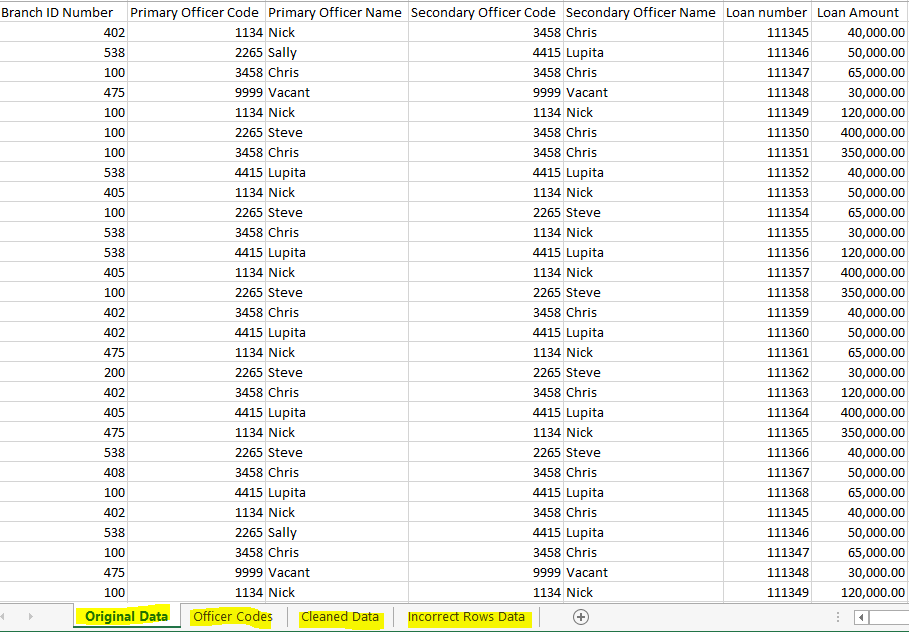

In [207]:
# last step.  Connecting to a sql server in order to load the cleaned data into a table.
# * used for security purposes 
conn = pyodbc.connect('DRIVER={*};'
                      'SERVER=*;'
                      'Trusted_connection=*;'
                      'username=*;'
                       'dbname=*')
cur = conn.cursor()    

In [208]:
# function that displays the SQL results into a dataframe for an cleaner look.  
def read_query(q):
    read = pd.read_sql(q, conn)
    return read

In [209]:
read_query("SELECT * FROM loan_files.dbo.loan_data") # shows only the columns are listed from the SQL table.

,branch_id_number,primary_officer_code,primary_officer_name,secondary_officer_code,secondary_officer_name,loan_number,loan_amount


In [210]:
# Inserting all of the updated/cleaned data from the clean_list.  
cur.executemany("""INSERT INTO loan_files.dbo.loan_data VALUES (?,?,?,?,?,?,?)""", clean_list) 

In [211]:
read_query("SELECT TOP 10 * FROM loan_files.dbo.loan_data") # displaying the first 10 rows.  

,branch_id_number,primary_officer_code,primary_officer_name,secondary_officer_code,secondary_officer_name,loan_number,loan_amount
0,402,1134,Nick,1134,Nick,111345,40000
1,100,3458,Chris,3458,Chris,111347,65000
2,100,1134,Nick,1134,Nick,111349,120000
3,100,2265,Steve,2265,Steve,111350,400000
4,100,3458,Chris,3458,Chris,111351,350000
5,538,4415,Lupita,4415,Lupita,111352,40000
6,405,1134,Nick,1134,Nick,111353,50000
7,100,2265,Steve,2265,Steve,111354,65000
8,538,3458,Chris,3458,Chris,111355,30000
9,538,4415,Lupita,4415,Lupita,111356,120000


In [212]:
# commiting the transaction and closing the connection.  
conn.commit()
cur.close()
conn.close()